In [0]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en


Redirecting output to ‘wget-log.1’.
Archive:  imdb.zip
replace test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.tsv                
replace train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.tsv               

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Тут придется авторизировать запрос к гугл драйву, извините.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Организационное

Страница курса: https://github.com/DanAnastasyev/DeepNLP-Course

Чатик: https://t.me/joinchat/DgDT4RLYhsTh_x6fRvfMjQ

Примерный план:

1. Введение
2. PyTorch, word embeddings
3. RNN 1, text classification
4. RNN 2, sequence labeling
5. RNN 3, text generation, language models
6. CNN, text classification
7. Machine translation, attention
8. Transformers
9. Dialogue systems 1, tagging + classification, multi-task learning
10. Dialogue systems 2, DSSM
11. Transfer learning
12. Tensorflow + xla/aot or Meta BiLSTM (?)

... and something else

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [0]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [0]:
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import eli5
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

In [0]:
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [0]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'favorite', 'excelent', 'this one beats them all', 'popular' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'emotionless', 'weak', 'soap', 'disappointment' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 67.63%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [0]:
pattern = re.compile('<[^>]+>')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [0]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://image.ibb.co/jJ5wX9/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [0]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Посмотрим на слова, попавшие в словарь:

In [0]:
vectorizer.get_feature_names()[-5:]

['ís', 'ísnt', 'østbye', 'über', 'üvegtigris']

Попробуем кого-нибудь таки сконвертировать

In [0]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74843 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://image.ibb.co/n9a25U/BOW_colored.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [0]:
dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40105812  0.40105812  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [0]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [0]:
positive_count = sum(train_df['is_positive'].values)
positive_count

12500

In [0]:
len(train_df['is_positive'].values) - positive_count

12500

In [0]:
eval_model(model, test_df)

Test accuracy = 86.66%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [0]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.586,refreshing
+1.411,wonderfully
+1.354,erotic
+1.297,funniest
+1.288,perfect
+1.282,excellent
+1.279,carrey
+1.261,superb
+1.250,surprisingly
+1.249,appreciated


Посмотрим на конкретные примеры его работы:

In [0]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [0]:
print('Positive' if test_df['is_positive'].iloc[0] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [0]:
preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [0]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.27%


In [0]:
eli5.show_weights(classifier, vec=vectorizer, top=10)

In [0]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.65%


In [0]:
eli5.show_weights(classifier, vec=vectorizer, top=10)

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.66%


In [0]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

In [0]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [0]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

train_docs = [doc for doc in nlp.pipe(train_df.review.values)]
test_docs = [doc for doc in nlp.pipe(test_df.review.values)]

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [0]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)
    
with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

In [0]:
train_texts = [' '.join([pair[1] for pair in doc[0]]) for doc in train_docs]
test_texts = [' '.join([pair[1] for pair in doc[0]]) for doc in test_docs]
train = pd.DataFrame({'is_positive': train_df['is_positive'], 'review': train_texts})
test = pd.DataFrame({'is_positive': test_df['is_positive'], 'review': test_texts})
train.head()

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train['review'], train['is_positive'])

eval_model(model, test)

Test accuracy = 88.50%


In [0]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+8.020,great
+5.262,excellent
+4.814,love
+4.504,and
+4.233,wonderful
+4.047,perfect
+4.011,well
+3.934,the good
+3.714,fun
+3.675,enjoy


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [0]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [0]:
train_texts = [' '.join([stemmer.stem(word) for word in doc.split()]) for doc in train_df.review.values]
test_texts = [' '.join([stemmer.stem(word) for word in doc.split()]) for doc in test_df.review.values]
train = pd.DataFrame({'is_positive': train_df['is_positive'], 'review': train_texts})
test = pd.DataFrame({'is_positive': test_df['is_positive'], 'review': test_texts})
train.head()

,is_positive,review
0,0,"dreamgirls, despit it fist of toni win in an i..."
1,0,thi show come up with interest locat as fast a...
2,1,I simpli love thi movie. I also love the ramon...
3,0,spoiler ahead if you want to call them that......
4,1,My all-tim favorit movie! I have seen mani mov...


In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train['review'], train['is_positive'])

eval_model(model, test)

Test accuracy = 88.29%


In [0]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+8.261,great
+5.671,love
+4.822,and
+4.589,excel
+4.581,enjoy
+4.471,best
+4.273,the best
+4.182,well
+4.181,perfect
+3.633,fun


**K:** Видимо,  у некоторых разных по смыслу слов/словосочетаний основа находится одиннаковая (топ слов немного другой, особенно у положительных)

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [0]:
displacy.render(train_docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [0]:
train = [' '.join([*map(lambda w: 'PERSON' if w.ent_type_ == 'PERSON' else 'GPE' if w.ent_type_ == 'GPE' else str(w), doc)]) for doc in train_docs]
test = [' '.join([*map(lambda w: 'PERSON' if w.ent_type_ == 'PERSON' else 'GPE' if w.ent_type_ == 'GPE' else str(w), doc)]) for doc in test_docs]

**K:** Убрали имена, и названия стран и городов

In [0]:
train = pd.DataFrame({'is_positive': train_df['is_positive'], 'review': train})
test = pd.DataFrame({'is_positive': test_df['is_positive'], 'review': test})
train.head()

,is_positive,review
0,0,"Dreamgirls , despite its fistful of PERSON win..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that ....
4,1,My all - time favorite movie ! I have seen man...


In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train['review'], train['is_positive'])

eval_model(model, test)

Test accuracy = 88.50%


## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

<a list of 223 Patch objects>

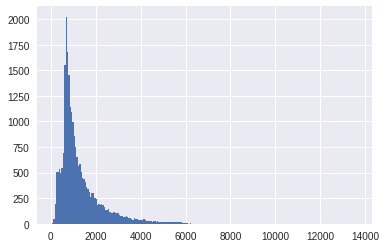

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text)), bins='auto')
hist

In [0]:
limit = 2000

Кроме этого, нужно перенумеровать как-то слова.

In [0]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))
count_limit = 700
word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < count_limit:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 759


In [0]:
idx2word = [word for word,_ in sorted(word2idx.items(), key=lambda x: x[1] )]
idx2word[:5]

['', '<unk>', 'the', 'a', 'and']

In [0]:
print(train_df.review.iloc[0].lower().split())
print(idx2word[word2idx.get(train_df.review.iloc[0].lower().split()[8], 1)])

['dreamgirls,', 'despite', 'its', 'fistful', 'of', 'tony', 'wins', 'in', 'an', 'incredibly', 'weak', 'year', 'on', 'broadway,', 'has', 'never', 'been', 'what', 'one', 'would', 'call', 'a', 'jewel', 'in', 'the', 'crown', 'of', 'stage', 'musicals.', 'however,', 'that', 'is', 'not', 'to', 'say', 'that', 'in', 'the', 'right', 'cinematic', 'hands', 'it', 'could', 'not', 'be', 'fleshed', 'out', 'and', 'polished', 'into', 'something', 'worthwhile', 'on-screen.', 'unfortunately,', 'what', 'transfers', 'to', 'the', 'screen', 'is', 'basically', 'a', 'slavishly', 'faithful', 'version', 'of', 'the', 'stage', 'hit', 'with', 'all', 'of', 'its', 'inherent', 'weaknesses', 'intact.', 'first,', 'the', 'score', 'has', 'never', 'been', 'one', 'of', 'the', 'strong', 'points', 'of', 'this', 'production', 'and', 'the', 'film', 'does', 'not', 'change', 'that', 'factor.', 'there', 'are', 'lots', 'of', 'songs', '(perhaps', 'too', 'many?),', 'but', 'few', 'of', 'them', 'are', 'especially', 'memorable.', 'the', '

**Задание** Сконвертируйте данные

In [0]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for i in range(len(texts)):
        for word in texts[i]:
            if word in word2idx:
                data[i][word2idx[word]] += 1
    return data

X_train = convert(train_df.review, word2idx, limit)
X_test = convert(test_df.review, word2idx, limit)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1),
    GlobalMaxPooling1D(),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 2000, 64)          48576     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1998, 128)         24704     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 73,409
Trainable params: 73,409
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=12, 
          validation_data=(X_test, test_df.is_positive))

Train on 25000 samples, validate on 25000 samples
Epoch 1/12
25000/25000 [==============================] - 18s 723us/step - loss: 0.6929 - acc: 0.5117 - val_loss: 0.6930 - val_acc: 0.5076
Epoch 2/12
25000/25000 [==============================] - 17s 688us/step - loss: 0.6910 - acc: 0.5257 - val_loss: 0.6932 - val_acc: 0.5124
Epoch 3/12
25000/25000 [==============================] - 17s 687us/step - loss: 0.6887 - acc: 0.5377 - val_loss: 0.6938 - val_acc: 0.5134
Epoch 4/12
25000/25000 [==============================] - 17s 687us/step - loss: 0.6862 - acc: 0.5442 - val_loss: 0.6955 - val_acc: 0.5144
Epoch 5/12
25000/25000 [==============================] - 17s 688us/step - loss: 0.6835 - acc: 0.5513 - val_loss: 0.6967 - val_acc: 0.5117
Epoch 6/12
25000/25000 [==============================] - 17s 691us/step - loss: 0.6816 - acc: 0.5557 - val_loss: 0.6967 - val_acc: 0.5125
Epoch 7/12
25000/25000 [==============================] - 17s 691us/step - loss: 0.6790 - acc: 0.5624 - val_loss: 0.

**Задание** Подсчитайте качество модели на тесте

In [0]:
model.evaluate(x=X_test, y=test_df.is_positive, batch_size=128)

25000/25000 [==============================] - 4s 165us/step


[0.7066595994567871, 0.514679999961853]

**K: ** Первое соотвественно - лосс, второе - аккураси. 
Я пробовала как-то поиграться с параметрами, но лучше не стало. Поэтому пусть будет пока так...


## Немного математики

Вспомним, как работает логистическая регрессия, которой мы тут столько пользовались.

Это обычная линейная функция

$$h_w(x) = \sigma(w^T x),$$
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Подсчитайте ее:

In [0]:
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import eli5
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

pattern = re.compile('<[^>]+>')

train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Train size = 25000
Test size = 25000


In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(train_df['review'], train_df['is_positive'])
X

<25000x1520214 sparse matrix of type '<class 'numpy.float64'>'
	with 8689349 stored elements in Compressed Sparse Row format>

In [0]:
def forward(x, w):
    return 1 / (1 + np.exp(-x * w))

Функция потерь 
$$J(w)  = \frac{1}{m} (-y^T \text{log}(h) + (1-y)^T \text{log}(1 - h)$$

Для оптимизации с SGD нужно считать градиент по функции потерь.

**Задание** Подсчитайте его.

In [0]:
def gradient(x, h, y):
    return np.gradient(1 / y.shape[0] * ( np.dot(-y, np.log(h)) + np.dot((1 -  y), np.log(1 - h)) ))

В итоге получим такой класс:

In [0]:
import scipy.sparse

class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        # should handle sparse matrix as well
        intercept = np.ones((X.shape[0], 1))
        return scipy.sparse.hstack((X, intercept))
        
    def fit(self, X, y):
        global T
        if self.fit_intercept:
            X = self.__add_intercept(X)
        T = X
        # weights initialization
#         self._w = np.zeros(X.shape[1])
        
#         for i in range(self.num_iter):
# #             h = 1 / (1 + np.exp(-np.dot(self._w, X)))
# #             grad = np.gradient(1 / y.shape[0] * ( np.dot(-y, np.log(h)) + np.dot((1 -  y), np.log(1 - h)) ))
# #             h = forward(X, self._w)
# #             grad = gradient(X, h, y)
#             self.w -= self.lr * grad
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return forward(X, self._w)
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression(fit_intercept=False)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tr...,
        vocabulary=None)), ('classifier', <__main__.LogisticRegression object at 0x7f350229a8d0>)])

In [0]:
eval_model(model, test_df)

# Сдача задания

Сдаем через [форму](https://goo.gl/forms/TWl14R42ddDPvZLU2).

И можно заполнить [анонимный опрос](https://goo.gl/forms/RII9cRcwoaJjPr2G3).